INSTALL ML LIBRARIES

In [ ]:
!pip install tensorflow opencv-python pillow numpy


IMPORT REQUIRED LIBRARIES

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image


LOAD PRETRAINED EFFICIENTNET MODEL

In [ ]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # freeze pretrained layers


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


ADD OUR CLASSIFICATION LAYERS (4 CLASSES)

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


COMPILE THE MODEL

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


IMAGE PREPROCESSING FUNCTION (VERY IMPORTANT)

In [ ]:
def preprocess_image(img):
    img = img.convert('RGB') # Convert image to RGB to ensure 3 channels
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0

    # Explicitly ensure the image array has 3 channels
    if img_array.ndim == 2:  # If it's grayscale (H, W)
        img_array = np.stack([img_array, img_array, img_array], axis=-1) # Becomes (H, W, 3)
    elif img_array.ndim == 3 and img_array.shape[-1] == 1: # If it's (H, W, 1)
        img_array = np.concatenate([img_array, img_array, img_array], axis=-1) # Becomes (H, W, 3)

    img = np.expand_dims(img_array, axis=0)
    return img

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving MRI_of_Human_Brain.jpg to MRI_of_Human_Brain.jpg


In [ ]:
img = Image.open('MRI_of_Human_Brain.jpg')  # use uploaded file name


RUN A TEST PREDICTION (NO DATASET NEEDED)

In [ ]:
processed_img = preprocess_image(img)


In [ ]:
pred = model.predict(processed_img)

class_names = [
    'Non-Demented',
    'Very Mild Demented',
    'Mild Demented',
    'Moderate Demented'
]

predicted_class = class_names[np.argmax(pred)]
confidence = np.max(pred)

print("Predicted Class:", predicted_class)
print("Confidence Score:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Mild Demented
Confidence Score: 0.29063192


GRAD-CAM FUNCTION

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv"):
    # Create a model that maps input image to activations of last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the conv outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()


In [ ]:
for layer in model.layers:
    if 'conv' in layer.name:
        print(layer.name)


stem_conv_pad
stem_conv
block1a_dwconv
block1a_project_conv
block2a_expand_conv
block2a_dwconv_pad
block2a_dwconv
block2a_project_conv
block2b_expand_conv
block2b_dwconv
block2b_project_conv
block3a_expand_conv
block3a_dwconv_pad
block3a_dwconv
block3a_project_conv
block3b_expand_conv
block3b_dwconv
block3b_project_conv
block4a_expand_conv
block4a_dwconv_pad
block4a_dwconv
block4a_project_conv
block4b_expand_conv
block4b_dwconv
block4b_project_conv
block4c_expand_conv
block4c_dwconv
block4c_project_conv
block5a_expand_conv
block5a_dwconv
block5a_project_conv
block5b_expand_conv
block5b_dwconv
block5b_project_conv
block5c_expand_conv
block5c_dwconv
block5c_project_conv
block6a_expand_conv
block6a_dwconv_pad
block6a_dwconv
block6a_project_conv
block6b_expand_conv
block6b_dwconv
block6b_project_conv
block6c_expand_conv
block6c_dwconv
block6c_project_conv
block6d_expand_conv
block6d_dwconv
block6d_project_conv
block7a_expand_conv
block7a_dwconv
block7a_project_conv
top_conv


GENERATE GRAD-CAM HEATMAP

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Get the last convolution layer
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Create a model that maps input to conv outputs and predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()


In [ ]:
heatmap = make_gradcam_heatmap(processed_img, model, last_conv_layer_name="top_conv")


OVERLAY GRAD-CAM ON MRI (FINAL VISUAL)

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

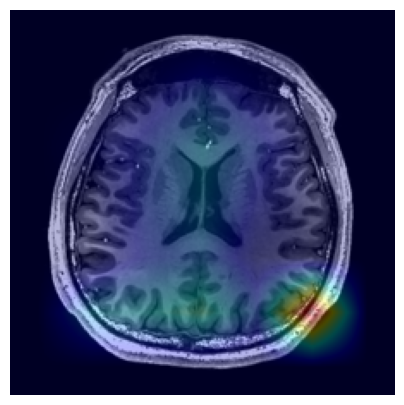

In [ ]:
import matplotlib.pyplot as plt

# Resize original image
img_rgb = img.convert("RGB")
img_array = np.array(img_rgb.resize((224, 224))).astype(float)


# Resize heatmap
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_resized = np.uint8(255 * heatmap_resized)

# Apply color map
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

# Overlay heatmap on image
superimposed_img = heatmap_color * 0.4 + img_array
superimposed_img = np.uint8(superimposed_img / np.max(superimposed_img) * 255)

# Display
plt.figure(figsize=(5,5))
plt.imshow(superimposed_img)
plt.axis('off')


SAVE THE GRAD-CAM IMAGE

In [ ]:
cv2.imwrite("gradcam_output.png", cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))


True

In [ ]:
model.save("alzheimer_model.h5")


In [ ]:
!ls


alzheimer_model.h5  gradcam_output.png	MRI_of_Human_Brain.jpg	sample_data


In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 115.4 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image

# -----------------------------
# Load trained model
# -----------------------------
model = tf.keras.models.load_model("alzheimer_model.h5")

class_names = [
    "Non-Demented",
    "Very Mild Demented",
    "Mild Demented",
    "Moderate Demented"
]

# -----------------------------
# Streamlit UI
# -----------------------------
st.title("Explainable AI-Based Alzheimer’s Disease Detection")
st.write("Upload a Brain MRI image to predict Alzheimer stage")

uploaded_file = st.file_uploader(
    "Choose an MRI image",
    type=["jpg", "png", "jpeg"]
)

# -----------------------------
# Image preprocessing
# -----------------------------
def preprocess_image(img):
    img = img.convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# -----------------------------
# Grad-CAM function
# -----------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv"):
    last_conv_layer = model.get_layer(last_conv_layer_name)

    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# -----------------------------
# Main logic
# -----------------------------
if uploaded_file is not None:
    img = Image.open(uploaded_file)

    st.subheader("Uploaded MRI Image")
    st.image(img, use_column_width=True)

    processed_img = preprocess_image(img)

    pred = model.predict(processed_img)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred)

    st.subheader("Prediction Result")
    st.write("Alzheimer Stage:", predicted_class)
    st.write("Confidence Score:", round(float(confidence), 2))

    # Grad-CAM
    heatmap = make_gradcam_heatmap(processed_img, model)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    img_rgb = img.convert("RGB").resize((224, 224))
    img_array = np.array(img_rgb)

    superimposed_img = heatmap * 0.4 + img_array
    superimposed_img = np.uint8(superimposed_img / np.max(superimposed_img) * 255)

    st.subheader("Grad-CAM Visualization")
    st.image(superimposed_img, use_column_width=True)


Overwriting app.py


In [ ]:
!streamlit run app.py --server.port 8501 --server.enableCORS false


2026-01-11 11:28:39.487 
'server.enableXsrfProtection=true'.
As a result, 'server.enableCORS' is being overridden to 'true'.

More information:
In order to protect against CSRF attacks, we send a cookie with each request.
To do so, we must specify allowable origins, which places a restriction on
cross-origin resource sharing.

If cross origin resource sharing is required, please disable server.enableXsrfProtection.
            



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.128.153:8501



In [ ]:
!cloudflared tunnel --url http://localhost:8501


In [ ]:
# @title AI prompt cell

import ipywidgets as widgets
from IPython.display import display, HTML, Markdown,clear_output
from google.colab import ai

dropdown = widgets.Dropdown(
    options=[],
    layout={'width': 'auto'}
)

def update_model_list(new_options):
    dropdown.options = new_options
update_model_list(ai.list_models())

text_input = widgets.Textarea(
    placeholder='Ask me anything....',
    layout={'width': 'auto', 'height': '100px'},
)

button = widgets.Button(
    description='Submit Text',
    disabled=False,
    tooltip='Click to submit the text',
    icon='check'
)

output_area = widgets.Output(
     layout={'width': 'auto', 'max_height': '300px','overflow_y': 'scroll'}
)

def on_button_clicked(b):
    with output_area:
        output_area.clear_output(wait=False)
        accumulated_content = ""
        for new_chunk in ai.generate_text(prompt=text_input.value, model_name=dropdown.value, stream=True):
            if new_chunk is None:
                continue
            accumulated_content += new_chunk
            clear_output(wait=True)
            display(Markdown(accumulated_content))

button.on_click(on_button_clicked)
vbox = widgets.GridBox([dropdown, text_input, button, output_area])

display(HTML("""
<style>
.widget-dropdown select {
    font-size: 18px;
    font-family: "Arial", sans-serif;
}
.widget-textarea textarea {
    font-size: 18px;
    font-family: "Arial", sans-serif;
}
</style>
"""))
display(vbox)
